In [330]:
import pandas as pd
import requests as r
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [331]:
api_key = "aBIdeyJp18dnYHxOLyICUOdCfrz7C2g1VFRdCQbx"


In [332]:
solar_monthly_url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=SPV&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"
wind_monthly_url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=WND&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [333]:
try:
    (request := r.get(solar_monthly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [334]:
json_data = request.json()

In [335]:
solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [336]:
solar_generation.head()

period location  ... generation        generation-units
0  2023-01       MO  ...    9.56056  thousand megawatthours
1  2022-12       MO  ...    7.20169  thousand megawatthours
2  2022-11       MO  ...    9.47591  thousand megawatthours
3  2022-10       MO  ...   14.40455  thousand megawatthours
4  2022-09       MO  ...   15.42541  thousand megawatthours

[5 rows x 9 columns]

In [337]:
solar_generation.period = pd.to_datetime(solar_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

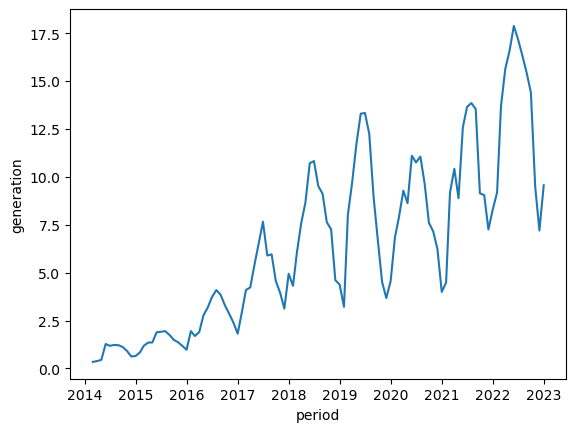

In [338]:
sns.lineplot(x="period",y="generation",data=solar_generation)

In [339]:
index=pd.DatetimeIndex(solar_generation.period).to_period("M")
y = pd.Series(solar_generation.generation.values, index=index)
arima = ARIMA(y,order=(2,0,2)).fit()

C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [340]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -191.038
Date:                Thu, 06 Apr 2023   AIC                            394.076
Time:                        14:20:55   BIC                            410.113
Sample:                             0   HQIC                           400.577
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4249      2.181      2.945      0.003       2.150      10.700
ar.L1          1.3939      0.278      5.023      0.000       0.850       1.938
ar.L2         -0.4780      0.261     -1.829      0.0

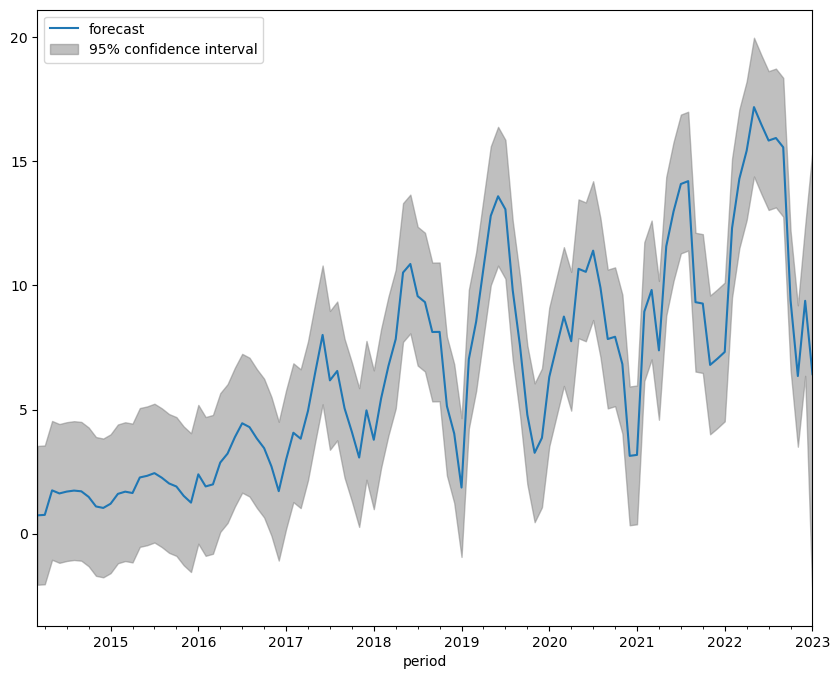

In [341]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima, ax=ax)
legend = ax.legend(loc="upper left")

In [342]:
sarimax = SARIMAX(y,order=(2,0,2),seasonal_order=(2,0,2,12)).fit()

C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jwj8c8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [343]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                -178.096
Date:                            Thu, 06 Apr 2023   AIC                            374.192
Time:                                    14:20:56   BIC                            398.247
Sample:                                         0   HQIC                           383.944
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2224      0.472      0.471      0.638      -0.703       1.148
ar.L2          0.6790      0.434      1.564      0.118      -0.172       1.530
ma.L1          0.7592      0.480      1.582      0.114      -0.182       1.700
ma.L2          0.0988      0.112      0.884      0.377      -0.120       0.318
ar.S.L12      -0.0374      4.508     -0.008      0.993      -8.874       8.799
ar.S.L24       0.8338      3.933      0.212      0.832      -6.875       8.543
ma.S.L12       0.4142      4.685      0.088      0.930      -8.768       9.596
ma.S.L24      -0.5070      2.260     -0.224      0.822      -4.936       3.922
sigma2         1.4756      0.273      5.402      0.000       0.940       2.011
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                12.46
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [344]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(sarimax, ax=ax)
legend = ax.legend(loc="upper left")

In [345]:
try:
    (request := r.get(wind_monthly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [346]:
json_data = request.json()

In [347]:
wind_generation = pd.DataFrame(json_data.get('response').get('data'))

In [348]:
wind_generation.head()

period location  ... generation        generation-units
0  2023-01       MO  ...  664.16199  thousand megawatthours
1  2022-12       MO  ...  765.94774  thousand megawatthours
2  2022-11       MO  ...  794.67596  thousand megawatthours
3  2022-10       MO  ...  568.17608  thousand megawatthours
4  2022-09       MO  ...  468.58903  thousand megawatthours

[5 rows x 9 columns]

In [349]:
wind_generation.period = pd.to_datetime(wind_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

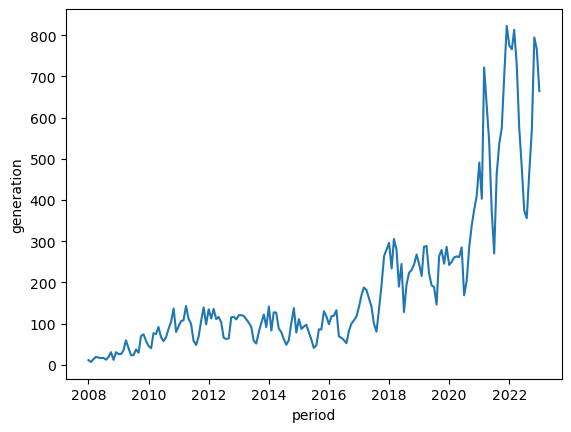

In [350]:
sns.lineplot(x="period",y="generation",data=wind_generation)

Hourly Prediction

In [351]:
solar_hourly_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[fueltype][]=SUN&facets[respondent][]=MISO&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"
wind_hourly_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[respondent][]=MISO&facets[fueltype][]=WND&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [352]:
try:
    (request := r.get(solar_hourly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [353]:
json_data = request.json()

In [354]:
hourly_solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [355]:
hourly_solar_generation.head()

period respondent  ... value    value-units
0  2023-04-06T05       MISO  ...     2  megawatthours
1  2023-04-06T04       MISO  ...     1  megawatthours
2  2023-04-06T03       MISO  ...     1  megawatthours
3  2023-04-06T02       MISO  ...     1  megawatthours
4  2023-04-06T01       MISO  ...    40  megawatthours

[5 rows x 7 columns]

In [356]:
hourly_solar_generation.period = pd.to_datetime(hourly_solar_generation.period,utc=True)


In [357]:
hourly_solar_generation.head()

period respondent  ... value    value-units
0 2023-04-06 05:00:00+00:00       MISO  ...     2  megawatthours
1 2023-04-06 04:00:00+00:00       MISO  ...     1  megawatthours
2 2023-04-06 03:00:00+00:00       MISO  ...     1  megawatthours
3 2023-04-06 02:00:00+00:00       MISO  ...     1  megawatthours
4 2023-04-06 01:00:00+00:00       MISO  ...    40  megawatthours

[5 rows x 7 columns]

In [358]:
sns.lineplot(x="period",y="value",data=hourly_solar_generation)

<AxesSubplot:xlabel='period', ylabel='value'>

In [359]:
try:
    (request := r.get(wind_hourly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [360]:
json_data = request.json()

In [361]:
hourly_wind_generation = pd.DataFrame(json_data.get('response').get('data'))

In [362]:
hourly_wind_generation.period = pd.to_datetime(hourly_wind_generation.period,utc=True)

In [363]:
hourly_wind_generation.head()

period respondent  ...  value    value-units
0 2023-04-06 05:00:00+00:00       MISO  ...  19851  megawatthours
1 2023-04-06 04:00:00+00:00       MISO  ...  20280  megawatthours
2 2023-04-06 03:00:00+00:00       MISO  ...  20676  megawatthours
3 2023-04-06 02:00:00+00:00       MISO  ...  21213  megawatthours
4 2023-04-06 01:00:00+00:00       MISO  ...  21309  megawatthours

[5 rows x 7 columns]

<AxesSubplot:xlabel='period', ylabel='value'>

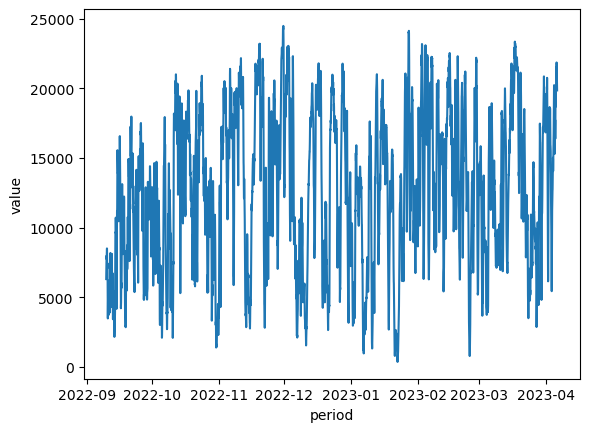

In [364]:
sns.lineplot(x="period",y="value",data=hourly_wind_generation)

Weather Data

In [365]:
weather_hourly_url = "https://api.weather.gov/stations/KSTL/observations?limit=500"

In [366]:
try:
    (request := r.get(weather_hourly_url))
    print("Successful")
except Exception as e:
    print(e)

Successful


In [367]:
json_data = request.json()

In [368]:
d= json.loads(request.text)

In [369]:
parsed = [d["features"][i]["properties"] for i in range(0,len(d["features"]))]

for i in range(0,len(parsed)):
    for key in parsed[i].keys():
        if isinstance(parsed[i][key],dict):
            if "value" in parsed[i][key]:
                parsed[i][key] = parsed[i][key]["value"]

In [370]:
hourly_observation_data = pd.DataFrame(parsed)

In [371]:
forecast_url = "https://api.weather.gov/gridpoints/LSX/89,80/forecast/hourly"

In [372]:
try:
    (request := r.get(forecast_url))
    print("Successful")
except Exception as e:
    print(e)

Successful


In [373]:
d = json.loads(request.text)

In [374]:
hourly_forecast_data = pd.DataFrame(d["properties"]["periods"])

In [375]:
hourly_forecast_data.head()

number name  ...  shortForecast detailedForecast
0       1       ...   Partly Sunny                 
1       2       ...   Partly Sunny                 
2       3       ...   Partly Sunny                 
3       4       ...   Partly Sunny                 
4       5       ...  Mostly Cloudy                 

[5 rows x 16 columns]

In [376]:
hourly_observation_data.head()

@id  ...                                        cloudLayers
0  https://api.weather.gov/stations/KSTL/observat...  ...  [{'base': {'unitCode': 'wmoUnit:m', 'value': 7...
1  https://api.weather.gov/stations/KSTL/observat...  ...  [{'base': {'unitCode': 'wmoUnit:m', 'value': 6...
2  https://api.weather.gov/stations/KSTL/observat...  ...  [{'base': {'unitCode': 'wmoUnit:m', 'value': 6...
3  https://api.weather.gov/stations/KSTL/observat...  ...                                                 []
4  https://api.weather.gov/stations/KSTL/observat...  ...  [{'base': {'unitCode': 'wmoUnit:m', 'value': 7...

[5 rows x 26 columns]

In [377]:
hourly_observation_data.columns

Index(['@id', '@type', 'elevation', 'station', 'timestamp', 'rawMessage',
       'textDescription', 'icon', 'presentWeather', 'temperature', 'dewpoint',
       'windDirection', 'windSpeed', 'windGust', 'barometricPressure',
       'seaLevelPressure', 'visibility', 'maxTemperatureLast24Hours',
       'minTemperatureLast24Hours', 'precipitationLastHour',
       'precipitationLast3Hours', 'precipitationLast6Hours',
       'relativeHumidity', 'windChill', 'heatIndex', 'cloudLayers'],
      dtype='object')

In [378]:
observation_columns_to_keep = ["timestamp","textDescription","temperature","windSpeed",'windDirection']
hourly_observation_data = hourly_observation_data.loc[:,observation_columns_to_keep]

In [379]:
##Temp will need to be converted to Celsius
forecast_columns_to_keep = ["startTime","isDaytime","temperature","windSpeed","windDirection","shortForecast"]
hourly_forecast_data = hourly_forecast_data.loc[:,forecast_columns_to_keep]

In [380]:
hourly_observation_data.timestamp = pd.to_datetime(hourly_observation_data.timestamp).dt.round("H")

In [381]:
hourly_observation_data.head()

timestamp textDescription  ...  windSpeed  windDirection
0 2023-04-06 19:00:00+00:00   Mostly Cloudy  ...      12.96          320.0
1 2023-04-06 18:00:00+00:00   Mostly Cloudy  ...       9.36          320.0
2 2023-04-06 17:00:00+00:00   Mostly Cloudy  ...      12.96          350.0
3 2023-04-06 16:00:00+00:00                  ...      11.16          340.0
4 2023-04-06 15:00:00+00:00   Mostly Cloudy  ...      12.96           20.0

[5 rows x 5 columns]

In [382]:
hourly_observation_data.shape

(197, 5)

In [383]:
hourly_forecast_data.startTime = pd.to_datetime(hourly_forecast_data.startTime).dt.round("H")

Merge data sets

In [384]:
solar_weather = hourly_solar_generation.merge(hourly_observation_data,left_on="period" ,right_on="timestamp",how="inner")

In [385]:
encoder = LabelBinarizer()
encoded_array = encoder.fit_transform(solar_weather.textDescription)

for i,class_ in enumerate(encoder.classes_):
    solar_weather.loc[:,f"description {class_}"] = encoded_array[:,i]
    
solar_weather.head()

period  ... description Thunderstorms and Rain and Fog/Mist
0 2023-04-06 05:00:00+00:00  ...                                               0
1 2023-04-06 04:00:00+00:00  ...                                               0
2 2023-04-06 03:00:00+00:00  ...                                               0
3 2023-04-06 02:00:00+00:00  ...                                               0
4 2023-04-06 01:00:00+00:00  ...                                               0

[5 rows x 31 columns]

In [386]:
solar_weather.set_index("period", inplace=True)

In [387]:
columns_to_drop = ["respondent","respondent-name","fueltype","type-name","timestamp","windSpeed","windDirection","value-units","textDescription"]
solar_weather.drop(columns_to_drop,axis=1,inplace=True)


In [389]:
solar_weather.dropna(inplace=True)

In [390]:
X = solar_weather.drop(["value"],axis=1)
y = solar_weather.value

In [391]:
X.dropna(inplace=True)
y.dropna(inplace=True)

In [392]:
X_train = X.iloc[:-24,:]
y_train = y.iloc[:-24]
X_test = X.iloc[-24:,:]
y_test = y.iloc[-24:]

In [393]:
y_test

period
2023-03-31 12:00:00+00:00       1
2023-03-31 10:00:00+00:00       0
2023-03-31 09:00:00+00:00       0
2023-03-31 09:00:00+00:00       0
2023-03-31 09:00:00+00:00       0
2023-03-31 08:00:00+00:00       0
2023-03-31 08:00:00+00:00       0
2023-03-31 07:00:00+00:00       0
2023-03-31 07:00:00+00:00       0
2023-03-31 06:00:00+00:00       0
2023-03-31 04:00:00+00:00       1
2023-03-31 04:00:00+00:00       1
2023-03-31 04:00:00+00:00       1
2023-03-31 03:00:00+00:00       2
2023-03-31 02:00:00+00:00       2
2023-03-31 01:00:00+00:00       8
2023-03-31 01:00:00+00:00       8
2023-03-31 00:00:00+00:00     234
2023-03-30 23:00:00+00:00     832
2023-03-30 22:00:00+00:00    1409
2023-03-30 21:00:00+00:00    1828
2023-03-30 20:00:00+00:00    1937
2023-03-30 19:00:00+00:00    2044
2023-03-30 18:00:00+00:00    2118
Name: value, dtype: int64

In [394]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [395]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0],1,X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0],1,X_test_scaled.shape[1]))

In [396]:
model=Sequential()
model.add(LSTM(50,input_shape=(X_train_scaled.shape[1],X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(loss="mae",optimizer="adam")

In [397]:
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=3,validation_data=(X_test_scaled,y_test))

Epoch 1/50
53/53 [==============================] - 6s 45ms/step - loss: 463.9009 - val_loss: 434.3584
Epoch 2/50
53/53 [==============================] - 0s 5ms/step - loss: 463.6839 - val_loss: 434.2463
Epoch 3/50
53/53 [==============================] - 0s 7ms/step - loss: 463.3108 - val_loss: 434.1097
Epoch 4/50
53/53 [==============================] - 0s 7ms/step - loss: 462.9894 - val_loss: 434.1348
Epoch 5/50
53/53 [==============================] - 0s 7ms/step - loss: 462.7133 - val_loss: 434.2890
Epoch 6/50
53/53 [==============================] - 0s 6ms/step - loss: 462.4095 - val_loss: 434.4956
Epoch 7/50
53/53 [==============================] - 0s 6ms/step - loss: 462.0747 - val_loss: 434.6909
Epoch 8/50
53/53 [==============================] - 0s 6ms/step - loss: 461.7109 - val_loss: 434.9222
Epoch 9/50
53/53 [==============================] - 0s 6ms/step - loss: 461.3226 - val_loss: 435.1233
Epoch 10/50
53/53 [==============================] - 0s 6ms/step - loss: 460.9669

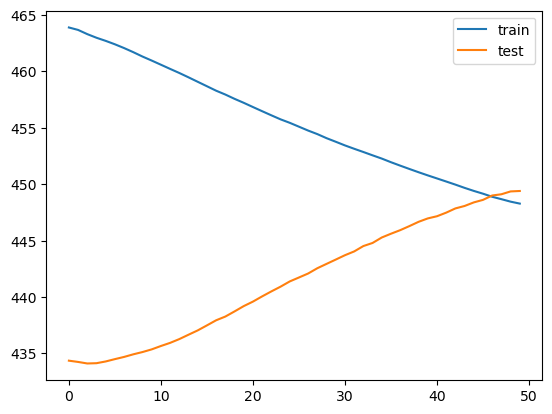

In [398]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [415]:
y_pred = model.predict(X_test_scaled)
y_pred

1/1 [==============================] - 0s 33ms/step


array([[43.7552  ],
       [44.234993],
       [39.98772 ],
       [57.347492],
       [39.537216],
       [37.40198 ],
       [42.35443 ],
       [37.968735],
       [58.54842 ],
       [11.897526],
       [38.99006 ],
       [57.347492],
       [55.61004 ],
       [45.47698 ],
       [59.767105],
       [22.922709],
       [15.634657],
       [47.0957  ],
       [50.533604],
       [51.191113],
       [18.456787],
       [58.893665],
       [58.731056],
       [16.210972]], dtype=float32)

In [406]:
y_test

period
2023-03-31 12:00:00+00:00       1
2023-03-31 10:00:00+00:00       0
2023-03-31 09:00:00+00:00       0
2023-03-31 09:00:00+00:00       0
2023-03-31 09:00:00+00:00       0
2023-03-31 08:00:00+00:00       0
2023-03-31 08:00:00+00:00       0
2023-03-31 07:00:00+00:00       0
2023-03-31 07:00:00+00:00       0
2023-03-31 06:00:00+00:00       0
2023-03-31 04:00:00+00:00       1
2023-03-31 04:00:00+00:00       1
2023-03-31 04:00:00+00:00       1
2023-03-31 03:00:00+00:00       2
2023-03-31 02:00:00+00:00       2
2023-03-31 01:00:00+00:00       8
2023-03-31 01:00:00+00:00       8
2023-03-31 00:00:00+00:00     234
2023-03-30 23:00:00+00:00     832
2023-03-30 22:00:00+00:00    1409
2023-03-30 21:00:00+00:00    1828
2023-03-30 20:00:00+00:00    1937
2023-03-30 19:00:00+00:00    2044
2023-03-30 18:00:00+00:00    2118
Name: value, dtype: int64

In [428]:
pd.concat([y_test.reset_index(drop=True),pd.Series(y_pred[:,0])],axis=1)

value          0
0       1  43.755199
1       0  44.234993
2       0  39.987720
3       0  57.347492
4       0  39.537216
5       0  37.401981
6       0  42.354431
7       0  37.968735
8       0  58.548420
9       0  11.897526
10      1  38.990059
11      1  57.347492
12      1  55.610039
13      2  45.476978
14      2  59.767105
15      8  22.922709
16      8  15.634657
17    234  47.095699
18    832  50.533604
19   1409  51.191113
20   1828  18.456787
21   1937  58.893665
22   2044  58.731056
23   2118  16.210972

In [429]:
y_pred_train = model.predict(X_train_scaled)

5/5 [==============================] - 0s 2ms/step


In [430]:
pd.concat([y_train.reset_index(drop=True),pd.Series(y_pred_train[:,0])],axis=1)

value          0
0        2  53.340137
1        1  41.484680
2        1  38.915993
3        1  38.915993
4       40  42.924110
..     ...        ...
153    963  50.398266
154    789  59.748238
155    533  58.731056
156    231  57.760452
157     40  47.590084

[158 rows x 2 columns]